In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    make_scorer
)
from sklearn.base import BaseEstimator
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline khusus untuk resampling
from sklearn.neighbors import KNeighborsClassifier

# Setup
RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

In [3]:
class SMOTE_IPF(BaseEstimator):
    """
    Custom sampler yang menggabungkan SMOTE dengan Iterative-Partitioning Filter (IPF)
    untuk membersihkan sampel noisy setelah oversampling.
    """
    def __init__(self, sampling_strategy='auto', smote_k=5, ipf_k=3,
                 max_iter=5, random_state=None, verbose=True):
        self.sampling_strategy = sampling_strategy
        self.smote_k = smote_k
        self.ipf_k = ipf_k
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def fit_resample(self, X, y):
        # 1. Lakukan SMOTE terlebih dahulu
        smote = SMOTE(
            sampling_strategy=self.sampling_strategy,
            k_neighbors=self.smote_k,
            random_state=self.random_state
        )
        X_res, y_res = smote.fit_resample(X, y)
        
        # 2. Iterative Filtering (IPF)
        # Menghapus data yang dianggap 'noisy' oleh kNN classifier
        for _ in range(self.max_iter):
            knn = KNeighborsClassifier(n_neighbors=self.ipf_k)
            knn.fit(X_res, y_res)
            y_pred = knn.predict(X_res)
            
            # Identifikasi sampel yang salah diklasifikasikan
            misclassified = y_pred != y_res
            
            # Jika tidak ada noise, berhenti
            if not np.any(misclassified):
                break
                
            # Hapus sampel yang salah klasifikasi (noise)
            # Fokus pada noise yang membuat kelas menjadi ambigu
            X_res = X_res[~misclassified]
            y_res = y_res[~misclassified]
            
        return X_res, y_res

In [4]:
df = pd.read_csv("framingham.csv")

# Pilih Fitur
selected_features = [
    "male", "age", "currentSmoker", "cigsPerDay", 
    "BPMeds", "prevalentHyp", "diabetes", "totChol"
]
target_col = "TenYearCHD"

# Pisahkan X dan y
X = df[selected_features]
y = df[target_col]

# Split Data (Stratified agar proporsi kelas terjaga)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Data Train: {X_train.shape}, Data Test: {X_test.shape}")
print(f"Proporsi Kelas 1 di Train: {y_train.mean():.2%}")

# Preprocessing Pipeline (Impute -> Scale)
# Kita fit scaler hanya di training data untuk mencegah data leakage
preprocessor = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Isi missing value dengan mean
    ('scaler', StandardScaler())                 # Standard scaling (mean=0, var=1)
])

# Transformasi data
X_train_prep = preprocessor.fit_transform(X_train, y_train)
X_test_prep = preprocessor.transform(X_test)

Data Train: (3392, 8), Data Test: (848, 8)
Proporsi Kelas 1 di Train: 15.18%


In [5]:
def evaluate_model(model_name, y_true, y_pred):
    print(f"\n{'='*10} {model_name} {'='*10}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Ambil metrics spesifik
    f1_class1 = f1_score(y_true, y_pred, pos_label=1)
    acc = accuracy_score(y_true, y_pred)
    
    return {"Model": model_name, "Accuracy": acc, "F1-Class 1": f1_class1}

results = []

In [6]:
svm_base = SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_STATE)
svm_base.fit(X_train_prep, y_train)
y_pred_base = svm_base.predict(X_test_prep)

res_base = evaluate_model("SVM Baseline (Weighted)", y_test, y_pred_base)
results.append(res_base)


========== SVM Baseline (Weighted) ==========
Confusion Matrix:
[[480 239]
 [ 52  77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       719
           1       0.24      0.60      0.35       129

    accuracy                           0.66       848
   macro avg       0.57      0.63      0.56       848
weighted avg       0.80      0.66      0.70       848



In [7]:
pipeline_smote = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('svm', SVC(kernel='rbf', random_state=RANDOM_STATE))
])

pipeline_smote.fit(X_train_prep, y_train)
y_pred_smote = pipeline_smote.predict(X_test_prep)

res_smote = evaluate_model("SVM + SMOTE", y_test, y_pred_smote)
results.append(res_smote)


========== SVM + SMOTE ==========
Confusion Matrix:
[[497 222]
 [ 58  71]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       719
           1       0.24      0.55      0.34       129

    accuracy                           0.67       848
   macro avg       0.57      0.62      0.56       848
weighted avg       0.80      0.67      0.71       848



In [8]:
pipeline_ipf = ImbPipeline([
    ('smote_ipf', SMOTE_IPF(random_state=RANDOM_STATE)),
    ('svm', SVC(random_state=RANDOM_STATE))
])

# Parameter Grid untuk Tuning
param_grid = {
    'smote_ipf__sampling_strategy': [0.75, 1.0, 'auto'], # Coba berbagai rasio resampling
    'svm__C': [0.1, 1, 10],                              # Regularization
    'svm__gamma': ['scale', 0.1],                        # Kernel coefficient
    'svm__kernel': ['rbf'],                              # RBF biasanya lebih baik untuk data kompleks
    'svm__class_weight': ['balanced', None]              # Penting! Cek apakah balanced membantu setelah SMOTE
}

# Scoring fokus ke F1 kelas positif (1)
scorer = make_scorer(f1_score, pos_label=1)

print("\nSedang melakukan Tuning Hyperparameter untuk SMOTE-IPF + SVM...")
grid_search = GridSearchCV(
    pipeline_ipf, 
    param_grid, 
    scoring=scorer, 
    cv=3, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_prep, y_train)

print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV F1-Score (Class 1): {grid_search.best_score_:.3f}")

# Evaluasi Model Terbaik di Data Test
best_model = grid_search.best_estimator_
y_pred_ipf = best_model.predict(X_test_prep)

res_ipf = evaluate_model("SVM + SMOTE-IPF (Tuned)", y_test, y_pred_ipf)
results.append(res_ipf)


Sedang melakukan Tuning Hyperparameter untuk SMOTE-IPF + SVM...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'smote_ipf__sampling_strategy': 0.75, 'svm__C': 0.1, 'svm__class_weight': None, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV F1-Score (Class 1): 0.376

========== SVM + SMOTE-IPF (Tuned) ==========
Confusion Matrix:
[[506 213]
 [ 62  67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       719
           1       0.24      0.52      0.33       129

    accuracy                           0.68       848
   macro avg       0.57      0.61      0.56       848
weighted avg       0.79      0.68      0.72       848



In [9]:
from sklearn.metrics import f1_score, precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_pred_ipf)

# Hitung f1 untuk semua threshold
f1s = 2 * prec * rec / (prec + rec + 1e-8)

best_idx = np.argmax(f1s)
best_thr = thr[best_idx]

print("Threshold terbaik:", best_thr)
print("F1 maksimum:", f1s[best_idx])


Threshold terbaik: 1
F1 maksimum: 0.3276283575397087


In [10]:
y_pred_custom = (y_pred_ipf >= best_thr).astype(int)


In [11]:
evaluate_model("SVM + SMOTE-IPF (Threshold Tuned)", y_test, y_pred_custom)



========== SVM + SMOTE-IPF (Threshold Tuned) ==========
Confusion Matrix:
[[506 213]
 [ 62  67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       719
           1       0.24      0.52      0.33       129

    accuracy                           0.68       848
   macro avg       0.57      0.61      0.56       848
weighted avg       0.79      0.68      0.72       848



{'Model': 'SVM + SMOTE-IPF (Threshold Tuned)',
 'Accuracy': 0.6757075471698113,
 'F1-Class 1': 0.3276283618581907}

=== Ringkasan Hasil Semua Skenario ===
                            Model  Accuracy  Precision   Recall  F1-score
SVM Baseline (Tanpa Oversampling)  0.656840   0.243671 0.596899  0.346067
                      SVM + SMOTE  0.669811   0.242321 0.550388  0.336493
                  SVM + SMOTE-IPF  0.675708   0.239286 0.519380  0.327628


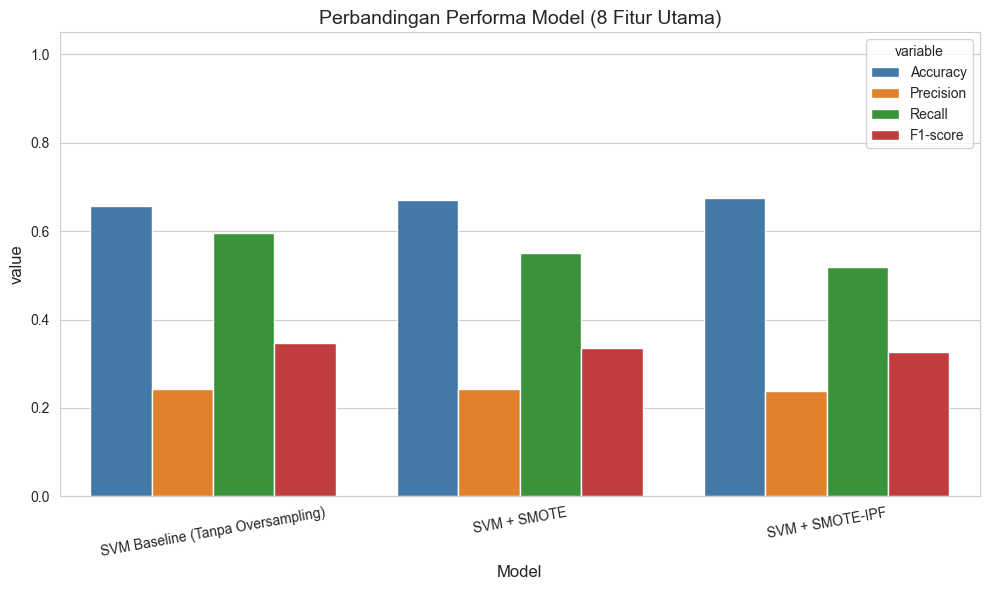

In [12]:


# 1. Kumpulkan Hasil Prediksi dalam Dictionary
# Pastikan variabel y_test, y_pred_base, y_pred_smote, dan y_pred_custom sudah ada dari sel sebelumnya
scenarios = [
    ("SVM Baseline (Tanpa Oversampling)", y_pred_base),
    ("SVM + SMOTE", y_pred_smote),
    ("SVM + SMOTE-IPF", y_pred_custom) # Menggunakan hasil threshold tuned
]

results_data = []

for model_name, y_pred in scenarios:
    results_data.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        # Kita fokus pada metrics kelas positif (1)
        "Precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1-score": f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    })

# 2. Buat DataFrame Ringkasan
df_results = pd.DataFrame(results_data)

# Tampilkan Tabel Teks
print("=== Ringkasan Hasil Semua Skenario ===")
print(df_results.to_string(index=False, float_format="%.6f"))

# 3. Visualisasi (Bar Chart)
# Ubah bentuk data agar bisa di-plot dengan seaborn (Melt)
df_melted = df_results.melt(id_vars="Model", var_name="variable", value_name="value")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid") # Mengatur style background grid

# Buat Grouped Bar Chart
ax = sns.barplot(
    data=df_melted,
    x="Model",
    y="value",
    hue="variable",
    palette=["#337ab7", "#ff7f0e", "#2ca02c", "#d62728"] # Warna mirip gambar (Biru, Orange, Hijau, Merah)
)

# Kustomisasi Plot
plt.title("Perbandingan Performa Model (8 Fitur Utama)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("value", fontsize=12)
plt.ylim(0, 1.05) # Set batas Y axis agar terlihat rapi
plt.legend(title="variable", loc='upper right')
plt.xticks(rotation=10) # Sedikit miringkan label X agar tidak bertumpuk

# Tampilkan Plot
plt.tight_layout()
plt.show()

In [ ]:
# 12. Ringkasan hasil

results_df = pd.DataFrame(results)
print("\n=== Ringkasan Hasil Semua Skenario ===")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1-score"]),
    x="Model", y="value", hue="variable"
)
plt.ylim(0, 1)
plt.title("Perbandingan Performa Model (8 Fitur Utama)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()